In [3]:

import importlib
import shiftNMF_frozen
importlib.reload(shiftNMF_frozen)
from shiftNMF_frozen import ShiftNMF
#from shiftNMFDiscTau import ShiftNMF
from nnls_l1 import nnls
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from helpers.generators import *
from helpers.data import X_ART, X_ART_NOISY, TAU_ART, W_ART, H_ART
from Hardmodel_single_peaks import Single_Model
from Hardmodel import Hard_Model
import scipy
from scipy.signal import find_peaks
import itertools
from helpers.fit_functions import *
from helpers.plot import *
import torch

# Data

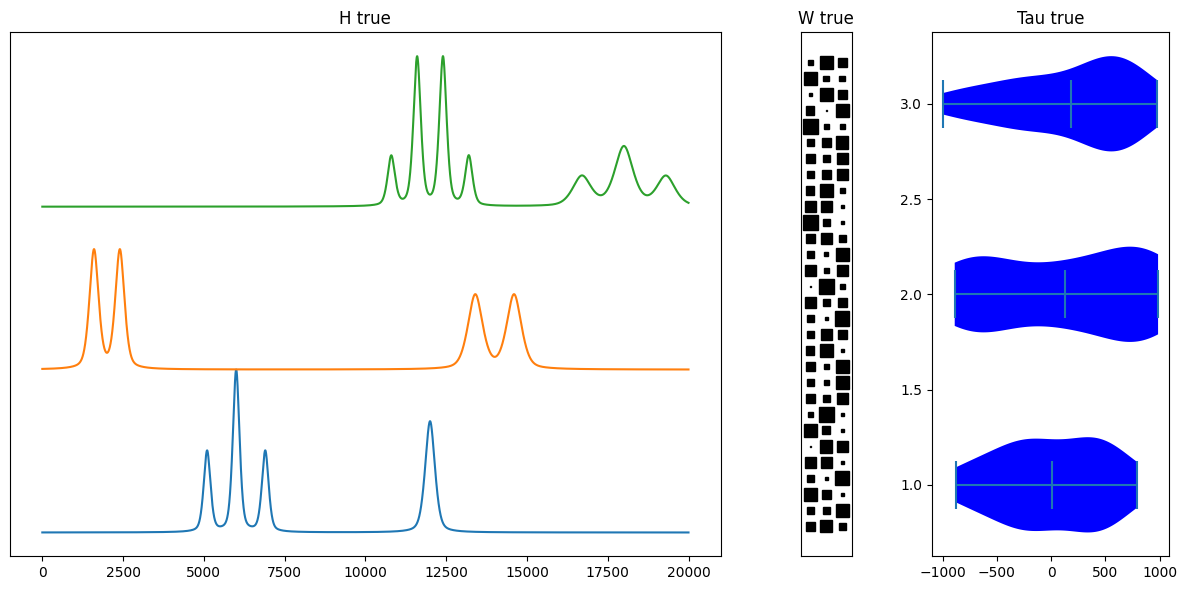

In [4]:
# Create a gridspec object with 2 rows and 3 columns
from helpers.plot import *
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 1, 1])

fig = plt.figure(figsize=(12, 6))
N, M = X_ART.shape

# Plot H and H_est
ax1 = plt.subplot(gs[0])
plotSpaced(ax1, np.arange(H_ART.shape[1]), H_ART.T)
ax1.set_title('H true')

ax2 = plt.subplot(gs[1])
ax2.set_title('W true')
hinton(W_ART.T, ax=ax2)

ax3 = plt.subplot(gs[2])
violin_parts = ax3.violinplot(TAU_ART, showmeans=True, showmedians=False, vert=False)
ax3.set_title('Tau true')
change_violin_colors(violin_parts, color_list=['blue']*N)
# change_violin_colors(violin_parts, [l.get_color() for l in ax3.get_children()[:3]])

# Set tight layout
plt.tight_layout()
plt.show()

# shiftNMF

epoch: 500, Loss: 0.07151675680516377, Tau: 6156.5433483408535
Found peaks:[ 2156  2962 13956 15156]
sigma: 143.60450179978537 n:0.0002647845338004824
sigma: 147.64928253672468 n:0.03303314246888194
sigma: 250.4281623716709 n:0.03448513359568689
sigma: 235.13209510783906 n:0.007202927144805548
Lorentzian %:s: 0.025022903406055994
tensor([8.2168e-15, 3.2070e-19, 1.8856e-13, 9.0292e-20],
       grad_fn=<SigmoidBackward0>)
Sigma:
Parameter containing:
tensor([153.4465, 159.8745, 269.0957, 252.6991], requires_grad=True)
hypothesises:
{(0, 1), (1, 3), (2,), (1, 2), (0, 1, 2), (0, 1, 3), (0, 3), (0, 2, 3), (1, 2, 3), (2, 3), (1,), (0, 2), (0, 1, 2, 3), (0,), (3,)}

initial values:
means:
tensor([ 2559.0000, 13956.0000,  6358.0000,  6758.0000, 14556.0000,  2962.0000,
         8557.5000,  2156.0000, 15156.0000])
sigmas:
Parameter containing:
tensor([156.6605, 269.0957, 194.1389, 188.6734, 260.8974, 159.8745, 208.7789,
        153.4465, 252.6991], requires_grad=True)
spacing(J-coupling):
Parame

c:\Users\Lenovo\OneDrive\Skrivebord\Bachelor project\Bachelorprojekt\nlars.py:64: LinAlgWarning: Ill-conditioned matrix (rcond=2.91556e-08): result may not be accurate.
  w = solve(XtX[np.ix_(A, A)], s)
c:\Users\Lenovo\OneDrive\Skrivebord\Bachelor project\Bachelorprojekt\nlars.py:64: LinAlgWarning: Ill-conditioned matrix (rcond=3.34528e-08): result may not be accurate.
  w = solve(XtX[np.ix_(A, A)], s)


epoch: 1, Loss: 0.026424265548590578
epoch: 2, Loss: 0.026424265548590578
means:
[12136.25  18136.    13335.8   15202.833 14875.2  ]
sigmas:
[129.90305 322.95096 161.87625 227.5235  210.09216]
J coupling:
[ 803. 1293.  803. 1609. 1609.]
multiplicity
[4 3 5 6 5]
N
[9.9927896e-01 4.6779587e-06 8.8536727e-01 9.1292137e-01 9.4506770e-01]
W:
[[  0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.       810.69543
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.       831.697      0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         9.731534   0.         0.         4.368623   0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.        12.856506   0.         0.         0.
    0.         0.         0.        

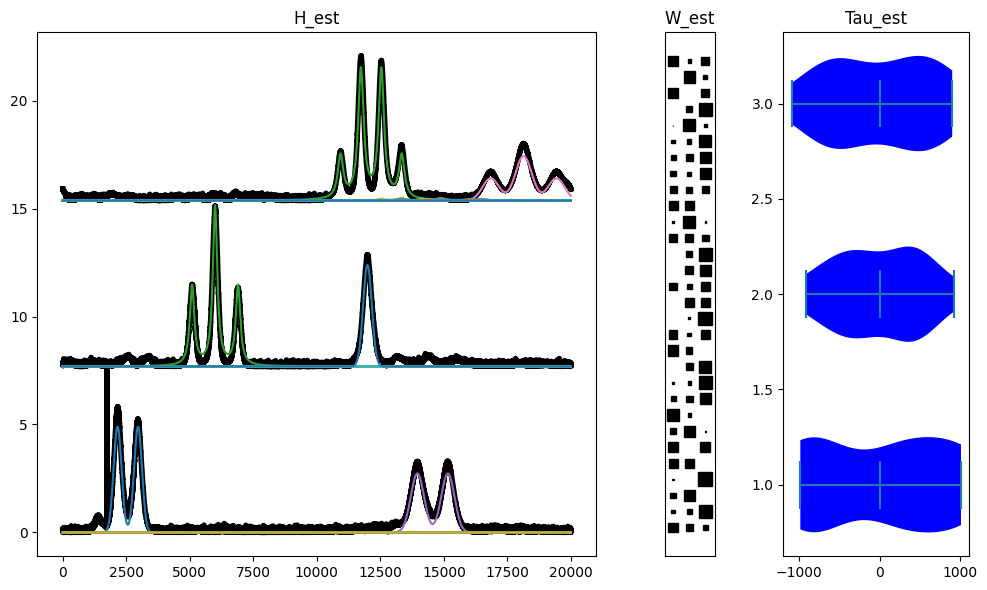

In [6]:

torch.manual_seed(40)

nmf = ShiftNMF(X_ART_NOISY, 3, lr=0.1, alpha=1e-6, patience=30, min_imp=0.001)
W_est, H_est, tau_est = nmf.fit(verbose=1, max_iter=500, tau_iter=0)

fig = plt.figure(figsize=(10, 6))
# Create a gridspec object with 2 rows and 3 columns
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 1, 1])

# Plot H and H_est
ax1 = plt.subplot(gs[0])
# plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
ax1.set_title('H_est')
x = np.arange(H_est.shape[1])

ax2 = plt.subplot(gs[1])
ax2.set_title('W_est')
hinton(W_est.T, ax=ax2)

ax3 = plt.subplot(gs[2])
violin_parts = ax3.violinplot(tau_est, showmeans=True, showmedians=False, vert=False)
ax3.set_title('Tau_est')
change_violin_colors(violin_parts, color_list=['blue']*3)
# change_violin_colors(violin_parts, [l.get_color() for l in ax3.get_children()[:3]])

# plt.figure(figsize=(15,5))
# plt.plot(H_est.T)
# plt.savefig("shiftcomponents")
# plt.clf()
ymax = 0
for i in range(len(H_est)):
    ymax = max(ymax,(H_est[i]/np.std(H_est[i])).max())
yoffset = ymax
reg_paths = []
lambda_axis = []
C_path = []

for i in range(len(H_est)):
    means, sigmas, n = single_fit(H_est[i])
    #diff_matrix = calc_difference_matrix(sigmas)
    diff_matrix = calc_difference_matrix(np.ones((len(sigmas))))
    hypothesis = peak_hypothesis(diff_matrix, cutoff=10/100)
    hardmodel = Hard_Model(H_est[i], hypothesis, means, sigmas, n, lr=10, alpha = 1e-3, factor=1, patience=1, min_imp=0.01)

    W, C, running_loss, path, lambdas = hardmodel.fit(verbose=True, return_loss=True)
    reg_paths.append(path)
    lambda_axis.append(lambdas)
    C_path.append(C)
    means, sigma, j_coup, mult, n = hardmodel.return_values()
    print("means:")
    print(means)
    print("sigmas:")
    print(sigma)
    print("J coupling:")
    print(j_coup)
    print("multiplicity")
    print(mult)
    print("N")
    print(n)

    print("W:")
    print(W)
    ## TODO change this to be the true underlying components from H_ART not the shift found components, they need to be scaled accordingly.
    # plt.figure(figsize=(15,5))
    # plt.plot(H_est[i]/np.std(H_est[i]), linewidth=5, color="k")
    ax1.plot(x,H_est[i]/np.std(H_est[i])+yoffset*i, linewidth=4, color="k")
    for j, vec in enumerate(C):
        ax1.plot(x,vec*W[:,j]+yoffset*i)
# Set tight layout
plt.tight_layout()
plt.show()

[ 7.49848685e+00  4.44517160e+00  5.60172046e-01  3.81890746e-01
  3.57922233e-01  2.82036705e-01  5.27636398e-02  2.96660518e-03
  1.19860520e-03 -4.67791738e-04]


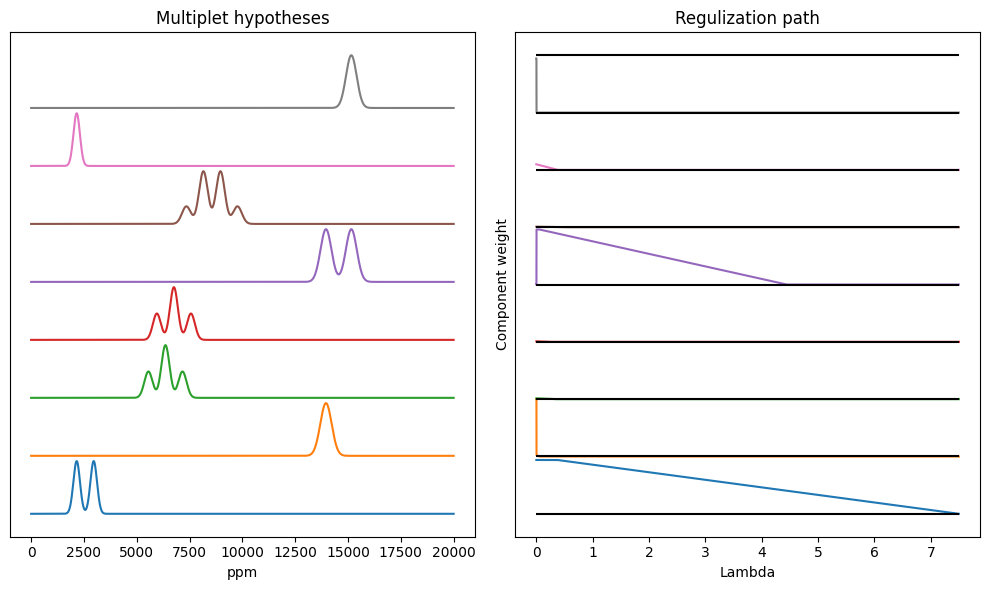

[ 1.21405911e+01  3.57911755e+00  2.61434230e-01  9.97797166e-02
  9.43805982e-02  3.60988036e-02  3.11837923e-03  2.96379562e-03
  2.69511524e-03  2.53501059e-03 -5.79998168e-05]


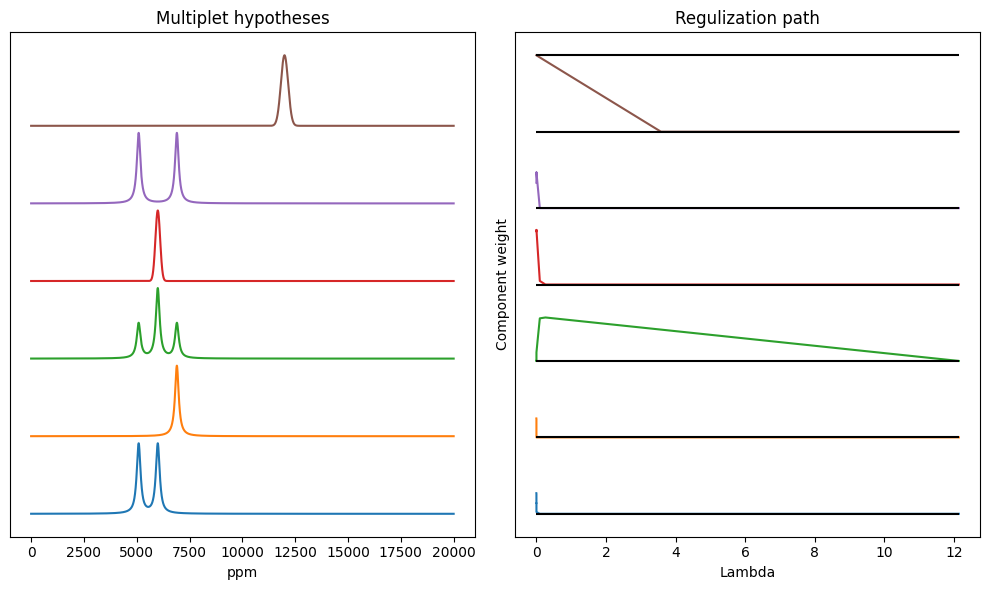

[ 2.99772644e+01  2.51729987e+01  2.31100365e+01  1.59978347e+01
  1.34090110e+01  5.78724836e+00  5.38358325e+00  5.13027219e+00
  4.28510590e+00  8.42126767e-01  7.24689875e-01  7.24151346e-01
  2.62630527e-01  2.05175856e-01  1.73403782e-01  1.70117348e-01
  1.26736242e-01  1.22462502e-01  8.24459008e-02  7.97986747e-02
  6.57529263e-02  6.48580212e-02  4.40653680e-02  3.86676801e-02
  3.35520246e-02  3.22632958e-02  2.19708279e-02  2.06603609e-02
  1.92479965e-02  1.79743279e-02  1.72821593e-02  1.33403996e-02
  1.03674817e-02  1.00848348e-02  8.89950951e-03  8.75333945e-03
  7.36979744e-03  7.35604491e-03  6.92500180e-03  6.91994806e-03
  6.74419500e-03  5.82104301e-03  5.81776411e-03  4.83901617e-03
  4.73073222e-03  4.72762022e-03  4.36764023e-03  4.27453434e-03
  4.02278799e-03  3.62854093e-03  3.37472556e-03  3.36736561e-03
  3.20753877e-03  1.57808677e-03  1.31225747e-03  1.13291670e-03
  6.45107219e-04  3.41480647e-04  1.87897377e-04  7.06347887e-05
  5.33177298e-05 -1.36202

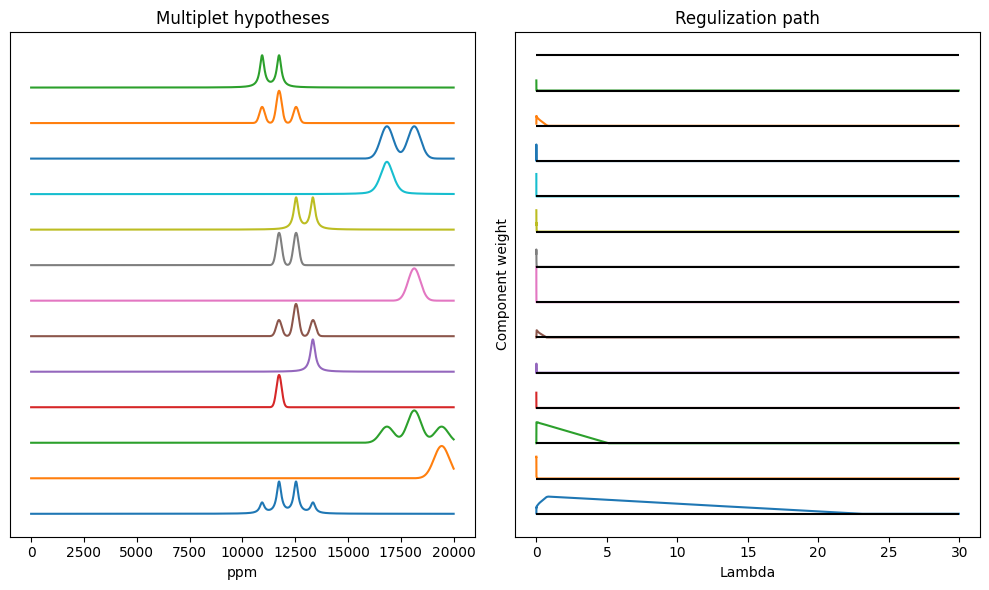

In [86]:

for i in range(len(reg_paths)):
    path = reg_paths[i]
    lambdas = lambda_axis[i]
    print(lambdas[0])
    C = C_path[i]

    fig = plt.figure(figsize=(10, 6))
    # Create a gridspec object with 2 rows and 3 columns
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    # Plot H and H_est
    ax1 = plt.subplot(gs[0])
    # plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
    ax1.set_title('Multiplet hypotheses')

    ax1.set_xlabel("ppm")
   
    x = np.arange(H_est.shape[1])

    ax2 = plt.subplot(gs[1])
    ax2.set_title('Regulization path')
    ax2.set_xlabel("Lambda")
    ax2.set_ylabel("Component weight")

    ax1.tick_params(left = False, labelleft = False)
    ax2.tick_params(left = False, labelleft = False)

    ymax = 1.1
    # for j, vec in enumerate(C):
    #     ymax = max(ymax,(C[j]/max(C[j])).max())

    cutoff = [0, 300, 300]

    yoffset = ymax
    t = 0
    for j, vec in enumerate(C):
        if any(path[0][j] > cutoff[i]):
            ax1.plot(x,vec/max(vec)+yoffset*t)
            t += 1

    
    ymax = path[0].max()
    yoffset = ymax
    t = 0
    for j, vec in enumerate(C):
        if any(path[0][j] > cutoff[i]):
            ax2.plot(lambdas[0],path[0][j]+yoffset*t)
            ax2.hlines(yoffset*t,lambdas[0][-1],lambdas[0][0], color="k")
            t +=1
    ax2.hlines(yoffset*t,lambdas[0][-1],lambdas[0][0], color="k")



    #plt.title("Hardmodelled component regulization path")
    #plt.plot(lambdas[0], reg_paths[i][0].T)
    # plt.savefig("fig"+str(i)+"_path")
    plt.tight_layout()
    plt.show()

# peak finding (single fit)

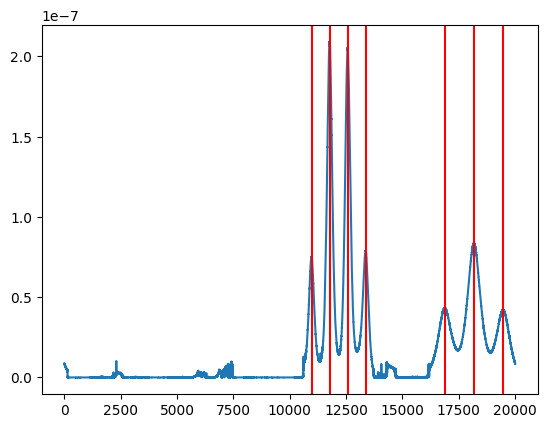

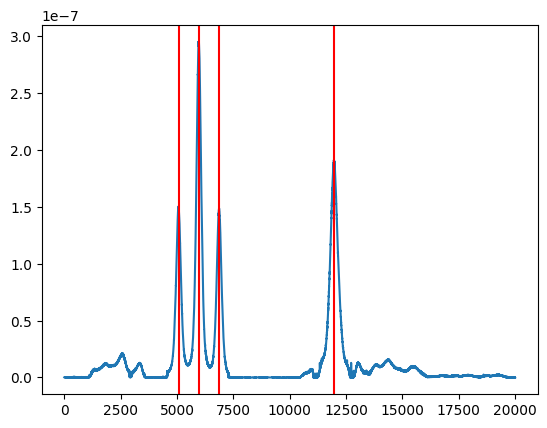

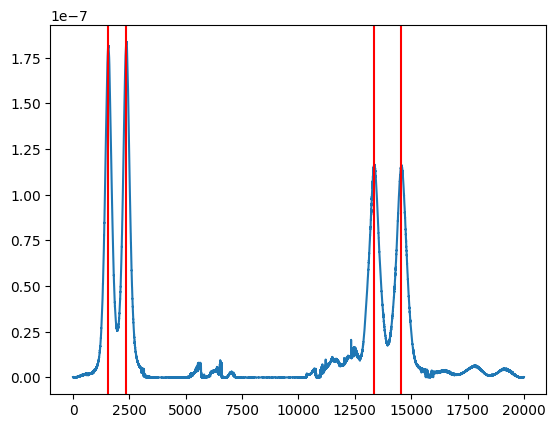

In [44]:

for i in range(len(H_est)):
    plt.plot(H_est[i])
    #peaks = find_peaks_cwt(H_est[i], [100,300])
    peaks = find_peaks(H_est[i], height=max(H_est[i])/10)[0]
    sigmas = scipy.signal.peak_widths(H_est[i], peaks, wlen=1000)[0]/2 #.355*1.5
    select = [sig>100 for sig in sigmas]
    select = [i for i, x in enumerate(select) if x == False]
    sigmas = np.delete(sigmas, select)
    peaks = np.delete(np.array(peaks), select)
    for mean in peaks:
        plt.axvline(mean, color='r')
    plt.show()

# Hardmodel

In [7]:
for i in range(len(H_est)):
    means, sigmas, n = single_fit(H_est[i])
    #diff_matrix = calc_difference_matrix(sigmas)
    diff_matrix = calc_difference_matrix(np.ones((len(sigmas))))
    hypothesis = peak_hypothesis(diff_matrix, cutoff=10/100)
    hardmodel = Hard_Model(H_est[i], hypothesis, means, sigmas, n, lr=10, alpha = 1e-3, factor=1, patience=1, min_imp=0.01)
    W, C = hardmodel.fit(verbose=True, alpha=0.2)
    print("W:")
    print(W)
    ## TODO change this to be the true underlying components from H_ART not the shift found components, they need to be scaled accordingly.
    plt.plot(H_est[i]/np.std(H_est[i]), linewidth=5)

    for i, vec in enumerate(C):
        plt.plot(vec*W[:,i])
    plt.title("C weigthed")
    plt.show()

Found peaks:[ 1391  2192 13194 14392]
sigma: 141.14353769260887 n:0.060371532175243194
sigma: 143.89461218231375 n:6.853583212927848e-07
sigma: 223.02381753766485 n:0.12253309517130631
sigma: 224.93228179371184 n:4.967621250322067e-06
Lorentzian %:s: 0.016332478651220457
tensor([2.5321e-13, 4.1765e-09, 1.7914e-12, 4.1246e-09],
       grad_fn=<SigmoidBackward0>)
Sigma:
Parameter containing:
tensor([149.7290, 150.5166, 241.6802, 234.9839], requires_grad=True)
hypothesises:
{(0, 1), (1, 3), (2,), (1, 2), (0, 1, 2), (0, 1, 3), (0, 3), (0, 2, 3), (1, 2, 3), (2, 3), (1,), (0, 2), (0, 1, 2, 3), (0,), (3,)}

initial values:
means:
tensor([ 1791.5000, 13194.0000,  5592.3335,  5991.6665, 13793.0000,  2192.0000,
         7792.2500,  1391.0000, 14392.0000])
sigmas:
Parameter containing:
tensor([150.1228, 241.6802, 180.6420, 178.4099, 238.3320, 150.5166, 194.2274,
        149.7290, 234.9839], requires_grad=True)
spacing(J-coupling):
Parameter containing:
tensor([ 801.,    0.,  801.,  801., 1198.,  

TypeError: Hard_Model.fit() got an unexpected keyword argument 'alpha'